# Imports

In [1]:
from Model import *
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd

# Loading the Datasets

In [2]:
#get the data
split_ratio = 0.8
val_ratio = 0.2
data = pd.read_csv("Data/dataset_2048.csv", dtype = str)
train_df = data.sample(frac = split_ratio)
test_df = data.drop(train_df.index)
val_df = train_df.sample(frac = val_ratio)
train_df = train_df.drop(val_df.index)

train_dataset = QueueDataset(train_df)
test_dataset = QueueDataset(test_df)
val_dataset = QueueDataset(val_df)

#initialize the data loader 
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 128, shuffle = True)

# Defining the Model

In [27]:
from Model import *
import torch.nn as nn
from torch.utils.data import DataLoader

#model hyperparameters 
ntokens = 65536  # size of vocabulary
emsize = 240  # embedding dimension
d_hid = 240  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 3  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 24 # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability
input_size = 128
threshold = 0.5
average = False

#define the model 
device = "cuda"
torch.cuda.empty_cache() if torch.cuda.is_available() else None
transformer = RandomLM(ntokens, emsize, nhead, d_hid, nlayers, input_size, dropout, averaging = average).to(device)
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(transformer.parameters())

/home/rishabhg/.conda/envs/Randomness-env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# Training Model

epoch: 1, batch: 100, train loss: 34.953, train macro: 0.454, train micro: 0.679, train sample: 0.615, train weighted 0.562, val loss: 35.668, val macro: 0.452, val micro: 0.679 val sample: 0.614 val weighted: 0.560
epoch: 1, batch: 200, train loss: 35.720, train macro: 0.454, train micro: 0.680, train sample: 0.616, train weighted 0.560, val loss: 35.668, val macro: 0.452, val micro: 0.679 val sample: 0.614 val weighted: 0.560
epoch: 1, batch: 300, train loss: 35.643, train macro: 0.453, train micro: 0.679, train sample: 0.615, train weighted 0.560, val loss: 35.668, val macro: 0.452, val micro: 0.679 val sample: 0.614 val weighted: 0.560
epoch: 1, batch: 400, train loss: 35.720, train macro: 0.451, train micro: 0.678, train sample: 0.613, train weighted 0.559, val loss: 35.668, val macro: 0.452, val micro: 0.679 val sample: 0.614 val weighted: 0.560
epoch: 1, batch: 500, train loss: 35.761, train macro: 0.452, train micro: 0.678, train sample: 0.614, train weighted 0.559, val loss: 3

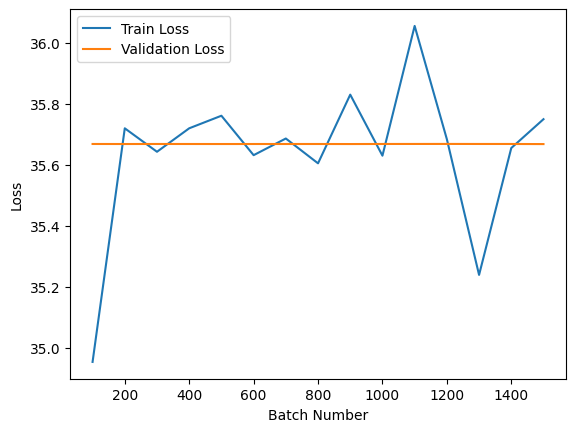

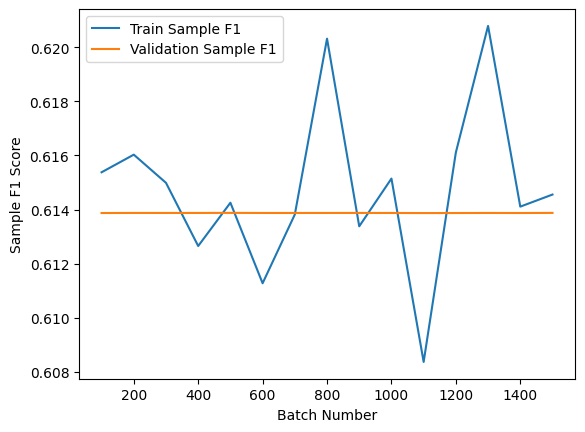

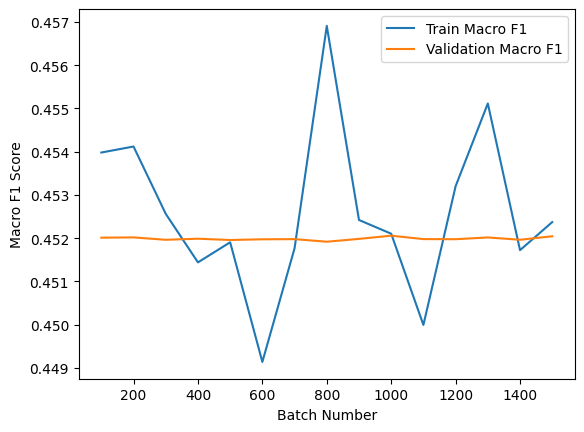

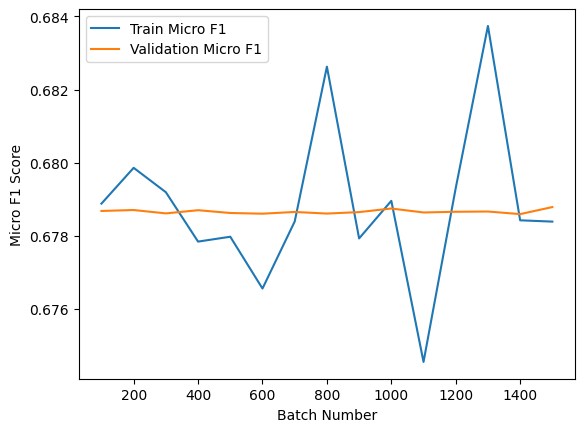

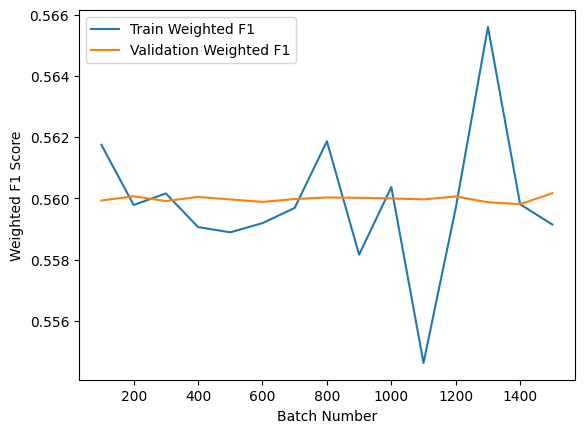

Loss: 35.692
Micro F1: 0.453
Macro F1: 0.679
Sample F1: 0.616
Weighted F1: 0.560


In [28]:
save = True 
path = str(emsize) + "embeddings-" + str(nlayers) + "encoder-" + str(nhead) + "heads-" + str(input_size) + "tokensize" + ("-large" if input_size == 128 else "") + ("-average" if average else "")

train_metrics, val_metrics = train(transformer, criterion, optimizer, train_loader, val_loader, 3, threshold, device = device)
plot_metrics(train_metrics, val_metrics)
inference(transformer, criterion, test_loader, threshold, device = device)
model_save(transformer, path, train_metrics, val_metrics)

# Pre-Trained Models

## Metrics

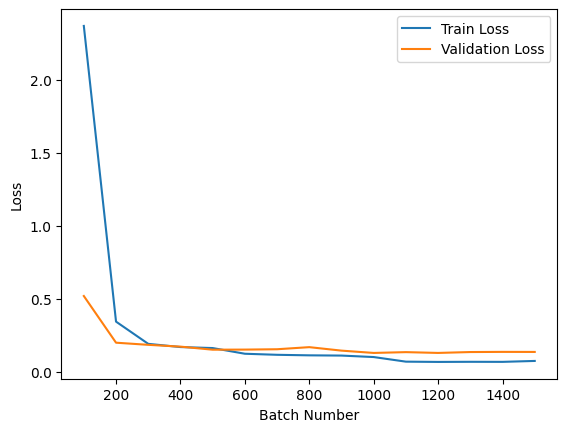

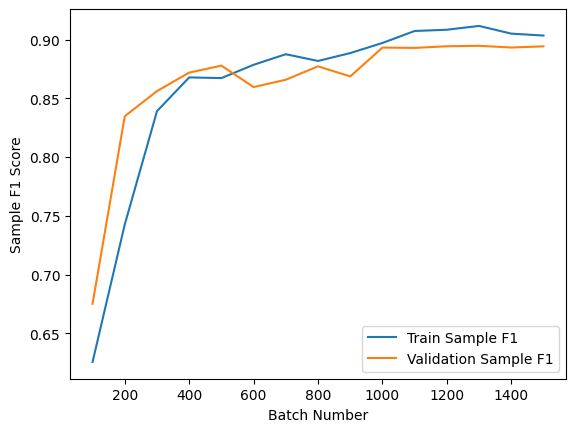

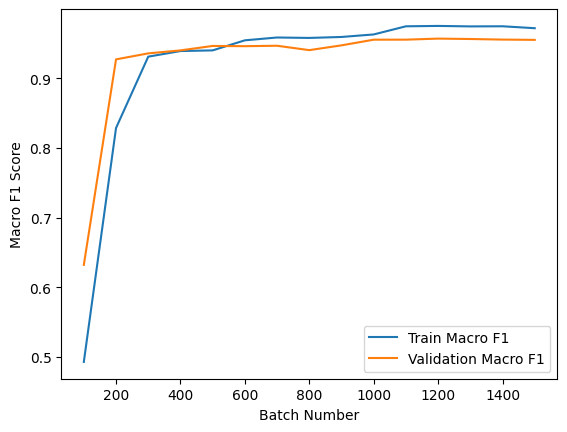

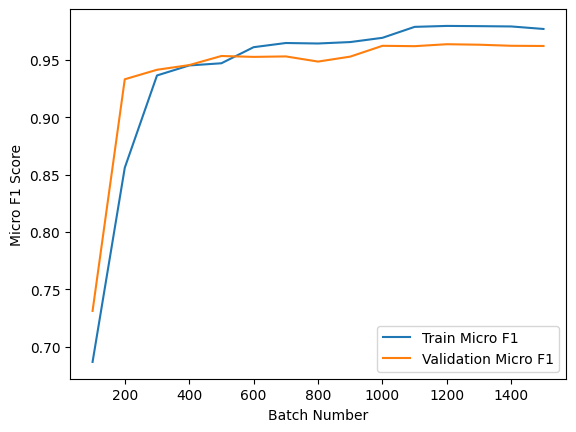

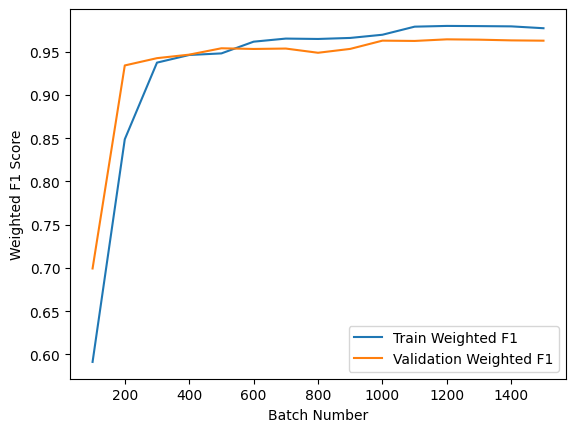

In [26]:
path = "TrainedModels/240embeddings-3encoder-24heads-128tokensize"

with ZipFile(path + ".zip", "r") as myzip:
    myzip.extractall("temp/")

train_metrics = pd.read_csv("temp/train_metrics.csv", index_col = 0)
val_metrics = pd.read_csv("temp/val_metrics.csv", index_col = 0)

plot_metrics(train_metrics, val_metrics)

## Inference

In [ ]:
model = torch.load("temp/model.pt")

# data_loader = None #loader for the data
# inference(model, criterion, test_loader, threshold)

In [2]:
import os 

os.remove("temp/train_metrics.csv")
os.remove("temp/val_metrics.csv")
if (os.path.exists("temp/model.pth")):
    os.remove("temp/model.pth")
if (os.path.exists("temp/model.pt")):
    os.remove("temp/model.pt")
os.rmdir("temp")